In [1]:
import torch
from torchvision import transforms
from torchsummary import summary
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm.auto import tqdm
from IPython.display import clear_output
from PIL import Image
import copy
import time
import os

from os import listdir
from shutil import copy2

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip drive/MyDrive/butterflies.zip
!unzip -qq butterflies/final_data.zip

Archive:  drive/MyDrive/butterflies.zip
  inflating: butterflies/final_data.zip  


In [5]:
data = pd.read_csv('final_data/train_labels.csv')
data

,filenames,label
0,train/0.jpg,12
1,train/1.jpg,33
2,train/2.jpg,4
3,train/3.jpg,42
4,train/4.jpg,26
...,...,...
4950,train/4950.jpg,33
4951,train/4951.jpg,26
4952,train/4952.jpg,34
4953,train/4953.jpg,30


In [6]:
os.mkdir('buffer_for_learning')
os.mkdir('buffer_for_learning/train')
for i in pd.unique(data['label']):
    os.mkdir('buffer_for_learning/train/' + str(i))

In [7]:
for name, label in data.values:
    copy2('final_data/' + name, 'buffer_for_learning/train/'+ str(label) + '/' + name.split('/')[1])

In [8]:
valid = pd.read_csv('final_data/valid_labels.csv')
valid

,filenames,label
0,valid/0.jpg,14
1,valid/1.jpg,40
2,valid/2.jpg,8
3,valid/3.jpg,37
4,valid/4.jpg,27
...,...,...
245,valid/245.jpg,32
246,valid/246.jpg,6
247,valid/247.jpg,2
248,valid/248.jpg,4


In [9]:
os.mkdir('buffer_for_learning/valid')
for i in pd.unique(valid['label']):
    os.mkdir('buffer_for_learning/valid/' + str(i))

In [10]:
for name, label in valid.values:
    copy2('final_data/' + name, 'buffer_for_learning/valid/'+ str(label) + '/' + name.split('/')[1])

In [11]:
DATA_PATH = r"buffer_for_learning"
NUM_WORKERS = 2
SIZE_H = SIZE_W = 96
NUM_CLASSES = 50
BATCH_SIZE = 256
EMBEDDING_SIZE = 128

image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

In [12]:
transformer = transforms.Compose([
    transforms.Resize((SIZE_H, SIZE_W)),
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std)
])

In [13]:
train_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'train'), transform=transformer)
val_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'valid'), transform=transformer)

In [14]:
n_train, n_val = len(train_dataset), len(val_dataset)
dataset_sizes = dict()
dataset_sizes['train'] = n_train
dataset_sizes['val'] = n_val
print(f'Train: {n_train}, val: {n_val}')

Train: 4955, val: 250


In [15]:
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)

val_batch_gen = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=BATCH_SIZE,
                                            num_workers=NUM_WORKERS)

dataloaders = dict()
dataloaders['val'] = val_batch_gen
dataloaders['train'] = train_batch_gen

In [16]:
def plot_from_batch_generator(batch_gen):
    data_batch, label_batch = next(iter(batch_gen))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)
    class_names = batch_gen.dataset.classes
    for i in range(grid_size[0] * grid_size[1]):
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])
        
        src = np.clip(image_std * batch_image_ndarray + image_mean, 0, 1)
        
        sample_title = 'Label = %s' % (class_names[label_batch[i]])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)
    pass

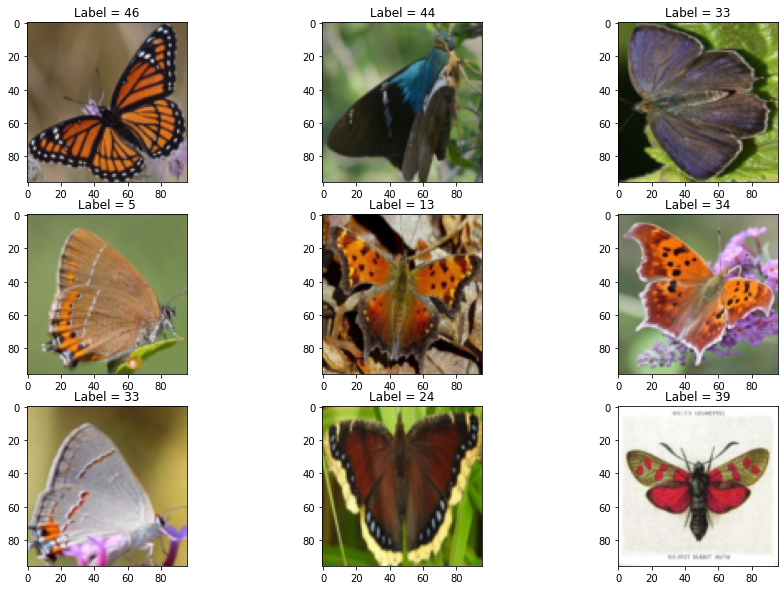

In [17]:
plot_from_batch_generator(train_batch_gen)

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    start_time = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_history = []
    val_acc_history = []
    train_acc_history = []

    for epoch in range(num_epochs):

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
   
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]


            if phase == 'val':
                loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
            else:
                train_acc_history.append(epoch_acc)

        clear_output(True)
        
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'{phase} loss: {epoch_loss:.4f}, val_acc: {val_acc_history[-1]:.4f}, train_acc: {train_acc_history[-1]:.4f}')
        
        plt.figure(figsize=(12, 6))

        plt.subplot(121)
        plt.plot(loss_history)
        plt.title('Train loss')
        
        plt.subplot(122)
        plt.plot(val_acc_history, label='val')
        plt.plot(train_acc_history, label='train')
        plt.title('Accuracy')
        plt.legend()

        plt.show()

    finish_time = time.time() - start_time
    print(f'Training complete in {finish_time // 60:.0f}m {finish_time % 60:.0f}s')
    print(f'Best val accuracy: {best_acc:4f}')

    model.load_state_dict(best_model_wts)

    return model

In [19]:
model_resnet = torchvision.models.resnet50(pretrained=True)
#for param in model_resnet.parameters():
#    param.requires_grad = False

num_feat = model_resnet.fc.in_features
model_resnet.fc = nn.Sequential(
    nn.Linear(num_feat, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),    
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),     
    nn.Linear(512, 50),
)
model_resnet = model_resnet.to(device)

summary(model_resnet, (3, SIZE_H, SIZE_W))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]           4,096
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
           Conv2d-11          [-1, 256, 24, 24]          16,384
      BatchNorm2d-12          [-1, 256, 24, 24]             512
           Conv2d-13          [-1, 256, 24, 24]          16,384
      BatchNorm2d-14          [-1, 256,

In [20]:
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model_resnet.parameters(), lr=1e-4)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)

Epoch 10/10
val loss: 0.2204, val_acc: 0.9680, train_acc: 0.9996


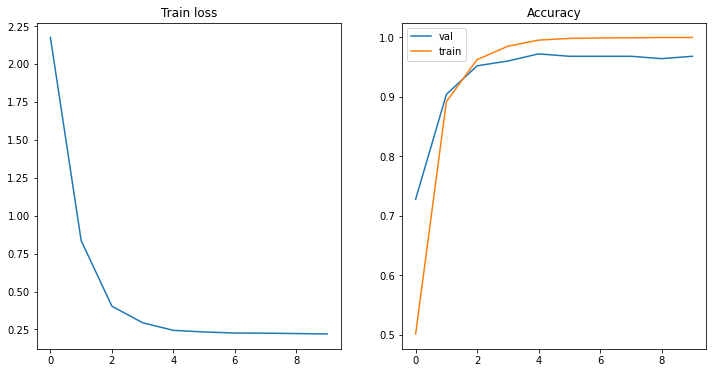

Training complete in 4m 30s
Best val accuracy: 0.972000


In [21]:
model = train_model(model_resnet, criterion, opt, exp_lr_scheduler, num_epochs=10)

In [22]:
result = []

class_names = train_batch_gen.dataset.classes

for test_image in os.listdir('final_data/test'):
  img = Image.open('final_data/test/' + test_image)
  input = transformer(img).reshape(1, 3, 96, 96).to(device)
  outputs = model(input)
  _, preds = torch.max(outputs, 1)

  result.append([test_image, class_names[preds.cpu().numpy()[0]]])                 

result = sorted(result, key = lambda x: int(x[0][:-4]))
df = pd.DataFrame(result, columns = ['filename', 'class'])
result = pd.DataFrame(df['class'])
result.to_csv('result.csv', index=False)
result

,class
0,15
1,32
2,49
3,19
4,22
...,...
245,22
246,11
247,20
248,29
